# ✅ Checklist Prático — Kaggle Diabetes

Este checklist resume as **boas práticas que realmente fizeram diferença** na competição Kaggle Diabetes, especialmente em cenários com **shift entre Train e Test** e uso de **ensemble de modelos**.

---

## 🧭 FASE 1 — ENTENDER O DADO (antes de qualquer modelo)

* ⬜ Verificar **Train ≈ Test**
  Comparar distribuições (histogramas, KS-test, PSI) e treinar **Adversarial Validation** (Train=0 / Test=1). AUC > 0.6 indica shift real.

* ⬜ Investigar **vazamento indireto**
  Testar `id`, ordem temporal e índices. Se uma feature “inútil” melhora muito o score, é alerta.

* ⬜ Identificar regiões **mais parecidas com o Test**
  Usar adversarial validation para ranquear amostras e separar **Head × Tail**.

* ⬜ Avaliar **Concept Shift**
  Bin das amostras por similaridade ao Test e comparar `target_mean`. Dados parecidos podem ter rótulos diferentes.

---

## 🧪 FASE 2 — DEFINIR A VALIDAÇÃO (ponto mais crítico)

* ⬜ Evitar **CV padrão automático**
  KFold aleatório falha quando existe shift.

* ⬜ Alinhar validação ao Test
  Usar Tail como validação, CV ponderado ou holdout dirigido (pseudo-test).

* ⬜ Checar **estabilidade do score**
  Modelo bom é consistente entre folds, não apenas com média alta.

---

## 🧱 FASE 3 — MODELOS BASE (diversidade > tuning)

* ⬜ Escolher modelos **conceitualmente diferentes**
  Linear (Ridge), GBDT (LGBM/XGB), NN simples, GAM.

* ⬜ Evitar micro-tuning excessivo
  Parâmetros razoáveis são suficientes. Priorizar ideias novas e features.

* ⬜ Definir o **papel de cada modelo**
  Linear captura tendência global; GBDT captura não linearidades; NN captura interações complexas.

---

## 🧠 FASE 4 — ENSEMBLE DE VERDADE

* ⬜ Gerar **OOF predictions corretas**
  Sempre usando a validação definida na FASE 2.

* ⬜ Combinar modelos com método otimizado
  Ridge, Stacking ou Hill Climbing. Evitar médias arbitrárias.

* ⬜ Verificar **estabilidade dos pesos**
  Pesos semelhantes entre seeds indicam ensemble robusto.

---

## 🧪 FASE 5 — VERIFICAÇÃO FINAL

* ⬜ Testar robustez
  Alterar seeds e folds; o score não pode colapsar.

* ⬜ Comparar single best × ensemble
  Ensemble só vale se melhora consistente e menor variância.

* ⬜ Gerar submissão final limpa
  Pipeline reproduzível, sem hacks temporários.

---

## 🚫 ARMADILHAS COMUNS

* ❌ CV aleatório com shift
* ❌ Tunagem obsessiva de hiperparâmetros
* ❌ Blind blending
* ❌ Confiar apenas no leaderboard público
* ❌ EDA sem hipótese ou objetivo

---

## 🧠 MANTRA FINAL

> **Dados → Validação → Modelos → Ensemble**
> *(Nunca o contrário)*


## Fase 1

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
# Importações locais
from pathlib import Path
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from src.preprocess_utils_diab import *

In [2]:
def basic_encode(train, test, target_col):
    train = train.copy()
    test = test.copy()

    cat_cols = train.select_dtypes(include=['object']).columns

    for col in cat_cols:
        le = LabelEncoder()
        all_vals = pd.concat([train[col], test[col]], axis=0).astype(str)
        le.fit(all_vals)

        train[col] = le.transform(train[col].astype(str))
        test[col]  = le.transform(test[col].astype(str))

    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]

    X_test = test.copy()

    return X_train, y_train, X_test

def adversarial_validation(X_train, X_test, n_splits=5):

    X_adv = pd.concat([X_train, X_test], axis=0)
    y_adv = np.concatenate([
        np.zeros(len(X_train)),
        np.ones(len(X_test))
    ])

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []

    for tr_idx, va_idx in skf.split(X_adv, y_adv):
        model = lgb.LGBMClassifier(
            objective='binary',
            n_estimators=300,
            learning_rate=0.05,
            num_leaves=31,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )

        model.fit(X_adv.iloc[tr_idx], y_adv[tr_idx])
        preds = model.predict_proba(X_adv.iloc[va_idx])[:, 1]
        aucs.append(roc_auc_score(y_adv[va_idx], preds))

    print(f"Adversarial AUC (Train vs Test): {np.mean(aucs):.4f}")
    return model
def id_leakage_test(train, target_col, id_col='id'):

    X = train[[id_col]]
    y = train[target_col]

    model = lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for tr, va in skf.split(X, y):
        model.fit(X.iloc[tr], y.iloc[tr])
        preds = model.predict_proba(X.iloc[va])[:, 1]
        aucs.append(roc_auc_score(y.iloc[va], preds))

    print(f"AUC usando apenas ID: {np.mean(aucs):.4f}")
def split_head_tail(train, id_col='id', quantile=0.8):
    cutoff = train[id_col].quantile(quantile)
    tail_mask = train[id_col] >= cutoff

    print(f"Cutoff ID (Tail): {cutoff:.0f}")
    print(f"Head size: {np.sum(~tail_mask)} | Tail size: {np.sum(tail_mask)}")

    return cutoff, tail_mask


def encode_for_lgb(train_df):
    """
    Encode categóricas apenas para análises adversariais.
    Não usar no pipeline final de modelagem.
    """
    df = train_df.copy()

    cat_cols = df.select_dtypes(include=['object']).columns

    for col in cat_cols:
        df[col] = df[col].astype('category').cat.codes

    return df
    
def head_tail_adversarial(train, tail_mask, target_col, id_col='id'):

    df = encode_for_lgb(train)

    X_tail = df.loc[tail_mask].drop(columns=[target_col, id_col])
    X_head = df.loc[~tail_mask].drop(columns=[target_col, id_col])

    y_tail = np.ones(len(X_tail))
    y_head = np.zeros(len(X_head))

    X_adv = pd.concat([X_head, X_tail], axis=0)
    y_adv = np.concatenate([y_head, y_tail])

    model = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    model.fit(X_adv, y_adv)

    head_similarity = model.predict_proba(X_head)[:, 1]
    return head_similarity

def concept_shift_analysis(train, tail_mask, head_similarity, target_col):

    df = train.loc[~tail_mask, [target_col]].copy()
    df['tail_similarity'] = head_similarity
    df['bin'] = pd.qcut(df['tail_similarity'], q=10, labels=False, duplicates='drop')

    agg = df.groupby('bin').agg(
        count=(target_col, 'count'),
        target_mean=(target_col, 'mean'),
        similarity_mean=('tail_similarity', 'mean')
    )

    tail_mean = train.loc[tail_mask, target_col].mean()

    print(agg)
    print(f"\nTail true target mean: {tail_mean:.4f}")

    return agg

In [3]:
BASE = Path.cwd().parent

DATA_DIR = BASE/"data"/"raw"
train = pd.read_csv(DATA_DIR/"train.csv")
test = pd.read_csv(DATA_DIR/"test.csv")


X_train, y_train, X_test=basic_encode(train, test, 'diagnosed_diabetes')

In [4]:
model=adversarial_validation(X_train, X_test, n_splits=5)


Adversarial AUC (Train vs Test): 1.0000


In [7]:
id_leakage_test(train, 'diagnosed_diabetes', id_col='id')

AUC usando apenas ID: 0.5006


In [8]:
cutoff, tail_mask=split_head_tail(train, id_col='id', quantile=0.8)

Cutoff ID (Tail): 559999
Head size: 560000 | Tail size: 140000


In [9]:
head_similarity=head_tail_adversarial(train, tail_mask, 'diagnosed_diabetes', id_col='id')

In [10]:
concept_shift_analysis(train, tail_mask, head_similarity, 'diagnosed_diabetes')

     count  target_mean  similarity_mean
bin                                     
0    56000     0.657232         0.179156
1    56000     0.654696         0.187539
2    56000     0.648857         0.189779
3    56000     0.644768         0.191530
4    56000     0.639839         0.193222
5    56000     0.636929         0.195106
6    56000     0.626375         0.197538
7    56000     0.606732         0.201223
8    56000     0.579196         0.207858
9    56000     0.541393         0.234274

Tail true target mean: 0.6221


,count,target_mean,similarity_mean
bin,,,
0,56000,0.657232,0.179156
1,56000,0.654696,0.187539
2,56000,0.648857,0.189779
3,56000,0.644768,0.191530
4,56000,0.639839,0.193222
5,56000,0.636929,0.195106
6,56000,0.626375,0.197538
7,56000,0.606732,0.201223
8,56000,0.579196,0.207858


In [11]:
def find_shift_features(train, test, target_col, id_col=None):
    train = train.copy()
    test  = test.copy()

    # Remove target
    train = train.drop(columns=[target_col])

    # Marca origem
    train["__is_test__"] = 0
    test["__is_test__"]  = 1

    # Junta
    df = pd.concat([train, test], axis=0, ignore_index=True)

    y = df["__is_test__"]
    X = df.drop(columns=["__is_test__"])

    if id_col is not None:
        X = X.drop(columns=[id_col])

    # Encode categóricas de forma simples
    for col in X.select_dtypes(include="object"):
        X[col] = X[col].astype("category").cat.codes

    return X, y

X_adv, y_adv = find_shift_features(
    train,
    test,
    target_col="diagnosed_diabetes",
    id_col="id"
)

model = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

model.fit(X_adv, y_adv)
pred = model.predict_proba(X_adv)[:, 1]
auc = roc_auc_score(y_adv, pred)
print(f"Adversarial AUC: {auc:.4f}")
importance = pd.DataFrame({
    "feature": X_adv.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

importance.head(15)


[LightGBM] [Info] Number of positive: 300000, number of negative: 700000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
Adversarial AUC: 0.6397


,feature,importance
14,triglycerides,1307
2,physical_activity_minutes_per_week,1171
11,cholesterol_total,929
6,bmi,915
0,age,630
13,ldl_cholesterol,596
8,systolic_bp,539
10,heart_rate,517
7,waist_to_hip_ratio,381
12,hdl_cholesterol,338


In [17]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,700000.0,349999.500000,202072.738554,0.00,174999.75,349999.50,524999.25,699999.00
age,700000.0,50.359734,11.655520,19.00,42.00,50.00,58.00,89.00
alcohol_consumption_per_week,700000.0,2.072411,1.048189,1.00,1.00,2.00,3.00,9.00
physical_activity_minutes_per_week,700000.0,80.230803,51.195071,1.00,49.00,71.00,96.00,747.00
diet_score,700000.0,5.963695,1.463336,0.10,5.00,6.00,7.00,9.90
sleep_hours_per_day,700000.0,7.002200,0.901907,3.10,6.40,7.00,7.60,9.90
screen_time_hours_per_day,700000.0,6.012733,2.022707,0.60,4.60,6.00,7.40,16.50
bmi,700000.0,25.874684,2.860705,15.10,23.90,25.90,27.80,38.40
waist_to_hip_ratio,700000.0,0.858766,0.037980,0.68,0.83,0.86,0.88,1.05
systolic_bp,700000.0,116.294193,11.010390,91.00,108.00,116.00,124.00,163.00


In [18]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,300000.0,849999.500000,86602.684716,700000.00,774999.75,849999.50,924999.25,999999.00
age,300000.0,50.432397,11.938741,19.00,42.00,50.00,59.00,89.00
alcohol_consumption_per_week,300000.0,2.089693,1.066214,1.00,1.00,2.00,3.00,9.00
physical_activity_minutes_per_week,300000.0,92.349087,62.187399,1.00,51.00,77.00,115.00,748.00
diet_score,300000.0,5.945838,1.481068,0.10,5.00,6.00,7.00,9.90
sleep_hours_per_day,300000.0,6.997795,0.914693,3.10,6.40,7.00,7.60,9.90
screen_time_hours_per_day,300000.0,6.011278,2.060472,0.60,4.60,6.00,7.40,15.90
bmi,300000.0,25.881906,2.894289,15.10,23.90,25.90,27.80,38.30
waist_to_hip_ratio,300000.0,0.859007,0.038523,0.69,0.83,0.86,0.89,1.05
systolic_bp,300000.0,116.374117,11.252146,91.00,108.00,116.00,124.00,170.00


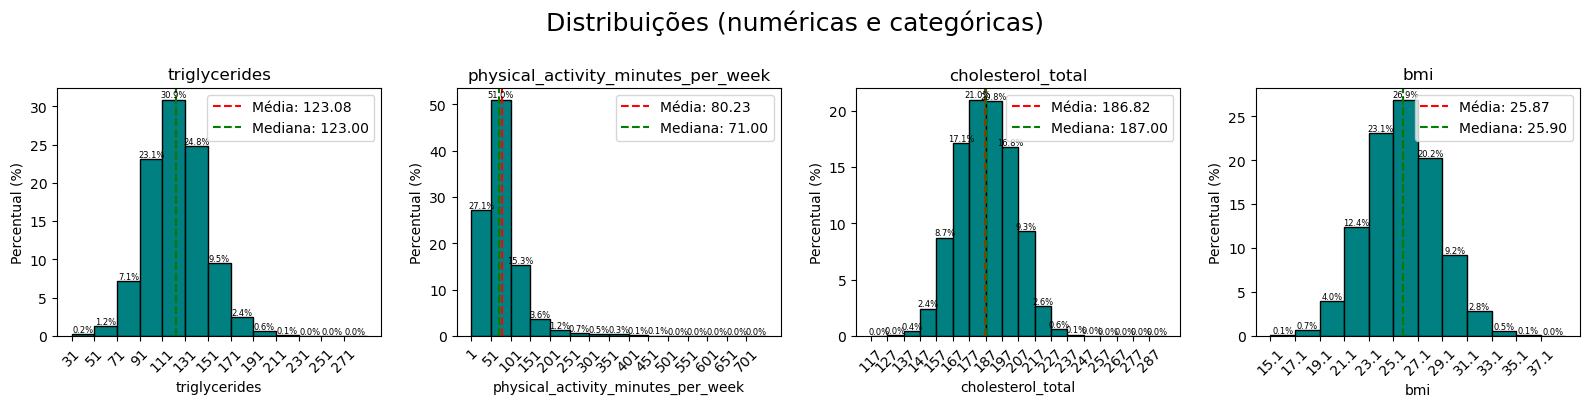

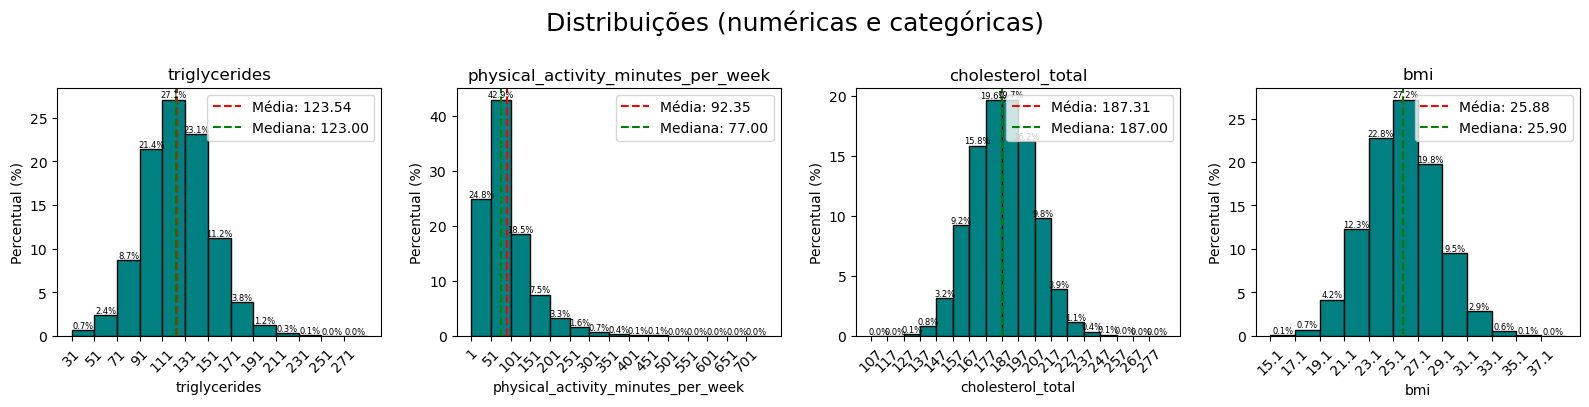

In [35]:
from src.functions import *

feature=['triglycerides','physical_activity_minutes_per_week','cholesterol_total','bmi']
train_hist=mult_plt2(train[feature],ncols=4,max_bins=20,figsize=(16,4))
test_hist=mult_plt2(test[feature],ncols=4,max_bins=20,figsize=(16,4))


In [39]:
import pandas as pd
from scipy.stats import ks_2samp

ks_results = []

for col in X_train.columns:
    x1 = X_train[col].dropna()
    x2 = X_test[col].dropna()
    
    stat, pvalue = ks_2samp(x1, x2, alternative='two-sided')
    
    ks_results.append({
        "feature": col,
        "ks_statistic": stat,
        "p_value": pvalue
    })

ks_df = (
    pd.DataFrame(ks_results)
      .sort_values("ks_statistic", ascending=False)
)

ks_df.head(10)



,feature,ks_statistic,p_value
0,id,1.000000,0.000000e+00
3,physical_activity_minutes_per_week,0.105923,0.000000e+00
15,triglycerides,0.042122,0.000000e+00
12,cholesterol_total,0.027913,1.421473e-142
14,ldl_cholesterol,0.024113,1.664605e-106
18,education_level,0.021773,6.488184e-87
11,heart_rate,0.010909,3.889975e-22
21,employment_status,0.010742,1.771110e-21
17,ethnicity,0.010722,2.121095e-21
10,diastolic_bp,0.008071,2.601992e-12


In [40]:
from scipy.stats import mannwhitneyu

mwu_results = []

for col in X_train.columns:
    x1 = X_train[col].dropna()
    x2 = X_test[col].dropna()
    
    stat, pvalue = mannwhitneyu(
        x1, x2,
        alternative='two-sided',
        method='asymptotic'  # importante p/ N grande
    )
    
    mwu_results.append({
        "feature": col,
        "u_statistic": stat,
        "p_value": pvalue
    })

mwu_df = (
    pd.DataFrame(mwu_results)
      .sort_values("p_value")
)

mwu_df.head(10)


,feature,u_statistic,p_value
0,id,0.000000e+00,0.000000e+00
3,physical_activity_minutes_per_week,9.414925e+10,0.000000e+00
18,education_level,1.029035e+11,4.343002e-68
21,employment_status,1.038549e+11,5.008778e-29
12,cholesterol_total,1.036399e+11,8.413414e-25
14,ldl_cholesterol,1.038568e+11,5.503814e-18
17,ethnicity,1.040010e+11,7.191188e-17
11,heart_rate,1.060562e+11,1.333396e-15
24,cardiovascular_history,1.047075e+11,2.024177e-13
15,triglycerides,1.040762e+11,2.871318e-12
